In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GPT(nn.Module):
    def __init__(self, vocab_size, block_size=256, embed_dim=64, num_layers=4):
        super().__init__()
        self.block_size = block_size
        self.transformer = nn.Sequential(
            nn.Embedding(vocab_size, embed_dim),
            nn.Sequential(*[Layer(block_size, embed_dim, (num_layers-n)/num_layers) for n in range(num_layers)]),
            nn.LayerNorm(embed_dim),
        )
        self.lm_head = nn.Linear(embed_dim, vocab_size, bias=False)
    
    def forward(self, x):
        return self.lm_head(self.transformer(x))

class Layer(nn.Module):
    def __init__(self, block_size, embed_dim, scale=1.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_dim)
        self.attn = AFTCustom(block_size, embed_dim, scale)
        self.ln2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, 4 * embed_dim),
            nn.GELU(approximate="tanh"),
            nn.Linear(4 * embed_dim, embed_dim),
        )
        self.register_buffer("mask", ~torch.tril(torch.ones(block_size, block_size)).to(bool))

    def forward(self, x):
        B, T, _ = x.shape
        x = x + self.attn(self.ln1(x), self.mask[:T, :T])
        x = x + self.mlp(self.ln2(x))
        return x

# https://arxiv.org/pdf/2105.14103.pdf
# I am not 100% sure this is correct but it seems to work :shrug:
# also, it seems to learn much faster than GPT but I am not sure why,
# maybe because it learns to separate positional attention from the rest?
# also, positions are approximated with 2 smaller matrices, and it seems that this is important
# (for some reason, 8 works much better than 32)
class AFTCustom(nn.Module):
    def __init__(self, block_size, embed_dim, scale=1.0):
        super().__init__()
        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.uv = nn.Parameter(torch.randn(2, block_size, 8) * 0.01 * scale, requires_grad=True)
        self.proj = nn.Linear(embed_dim, embed_dim, bias=False)
        
        with torch.no_grad():
            self.qkv.weight *= scale
            self.proj.weight *= scale
    
    def forward(self, x, mask):
        B, T, C = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        w = self.uv[0, :T] @ self.uv[1, :T].T # (T, T)
        w.masked_fill_(mask[:T, :T], float("-Inf"))

        exp_w = w.unsqueeze(0).exp() # (1, T, T)
        exp_k = k.clamp(max=20).exp() # (B, T, C)

        wkv = exp_w @ (exp_k * v) # (B, T, C)
        wk = exp_w @ exp_k # (B, T, C)
        Yt = F.sigmoid(q) * (wkv / wk)
        return self.proj(Yt)

In [2]:
import lightning as pl
from shared import corpus, tokenizers, trainers

text = corpus.shakespeare()
tokenizer = tokenizers.unique_chars(text)

pl.seed_everything(89026614)
model = GPT(tokenizer.get_vocab_size())
trainer = trainers.CausalTrainer(model, tokenizer, device = "mps")
trainer.train(text, batch_size=36, epochs=25)

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset tiny_shakespeare (/Users/cztomsik/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/b5b13969f09fe8707337f6cb296314fbe06960bd9a868dca39e713e163d27b5e)
100%|██████████| 3/3 [00:00<00:00, 984.58it/s]
Global seed set to 89026614
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.63it/s]And nowCKKZrO;zHvdO:3KKY3Hg&y;YdkO;uEST!Hz!OlJEUghT qWxYzL;sOXWQHHHHHz-
                                                                           

/Users/cztomsik/miniconda3/envs/torch-mps/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 202/202 [00:08<00:00, 23.29it/s, loss=2.18, v_num=71]And now somed bedes a noonce not. Thinth, nuredst hake beare
The a my t
Epoch 1: 100%|██████████| 202/202 [00:07<00:00, 26.97it/s, loss=1.65, v_num=71, test_loss=2.180]And nows, the so purder,
That what's shath will thees must a barish
And
Epoch 2: 100%|██████████| 202/202 [00:07<00:00, 27.01it/s, loss=1.48, v_num=71, test_loss=1.800]And now thou
hadst is denight the predsenge begeth thee,
The hones-trif
Epoch 3: 100%|██████████| 202/202 [00:07<00:00, 26.83it/s, loss=1.42, v_num=71, test_loss=1.600]And now there were come that lead tell.

COMINIUS:
O, may, my lord, but
Epoch 4: 100%|██████████| 202/202 [00:07<00:00, 26.67it/s, loss=1.37, v_num=71, test_loss=1.560]And now; for men!
Have stains I thou have a tly world I warrant such a 
Epoch 5: 100%|██████████| 202/202 [00:07<00:00, 26.65it/s, loss=1.34, v_num=71, test_loss=1.500]And now hath sweat, friends a like-folger
Till thy tignor bears unsurte
Epoch 6: 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 202/202 [00:11<00:00, 16.85it/s, loss=1.15, v_num=71, test_loss=1.370]


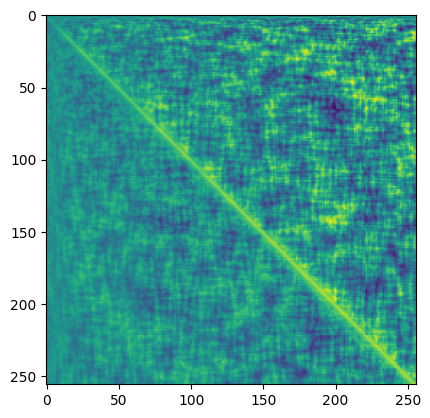

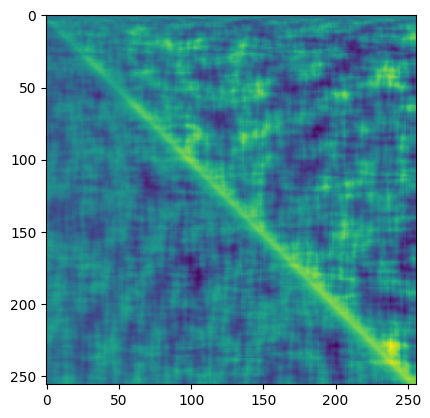

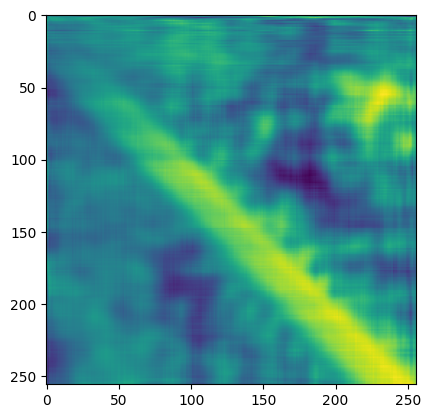

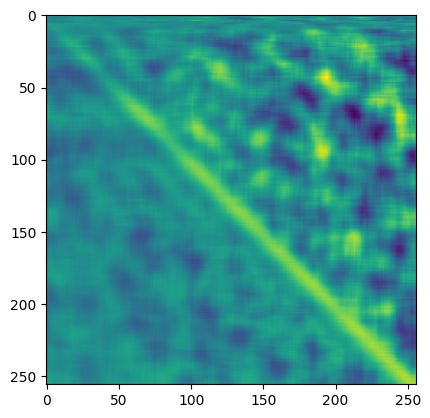

In [4]:
from matplotlib import pyplot as plt
for b in trainer.wrapper.model.transformer[1]:
    plt.figure()
    plt.imshow((b.attn.uv[0] @ b.attn.uv[1].T).detach().numpy())

In [5]:
print(trainer.wrapper.generate("O God, O God!", 650))

O God, O God!

FLORESCERS:
That horse! her is meeting to the seats makes
We asset marries, widwanting a living one.
I'll set down this merry of all guides,
Thou shalt livellia till subs age my containtness
Will thou drudge my will, how do the words
In office in this beauty's wave behind.

Shepherd:
Lieuted me; and so hear our heart with a fled.
A temption blessed bosom a highness say,
Make no more robed soul, with wishing one substance;
For I raise all unsoin'd my husband
Had shed temport.

BRUTUS:
If you have done to the common
Doth contempt from our cold dismidier:
My husband, will not be break'd and his nativity
That was so discord's and highing approo
